# House Prices: Advanced Regression Techniques

## Paquetes

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

## Datasets

Cargamos los datasets:

+ https://www.kaggle.com/c/house-prices-advanced-regression-techniques

In [77]:
df = pd.read_csv("../../../Challenges/kaggle/house_prices/train.csv", index_col=["Id"])
df.head()

MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
Id                                                                    
1           60       RL         65.0     8450   Pave   NaN      Reg   
2           20       RL         80.0     9600   Pave   NaN      Reg   
3           60       RL         68.0    11250   Pave   NaN      IR1   
4           70       RL         60.0     9550   Pave   NaN      IR1   
5           60       RL         84.0    14260   Pave   NaN      IR1   

   LandContour Utilities LotConfig  ... PoolArea PoolQC Fence MiscFeature  \
Id                                  ...                                     
1          Lvl    AllPub    Inside  ...        0    NaN   NaN         NaN   
2          Lvl    AllPub       FR2  ...        0    NaN   NaN         NaN   
3          Lvl    AllPub    Inside  ...        0    NaN   NaN         NaN   
4          Lvl    AllPub    Corner  ...        0    NaN   NaN         NaN   
5          Lvl    AllPub       FR2  ...        0    NaN   NaN         NaN   

   MiscVal MoSold  YrSold  SaleType  SaleCondition  SalePrice  
Id                                                             
1        0      2    2008        WD         Normal     208500  
2        0      5    2007        WD         Normal     181500  
3        0      9    2008        WD         Normal     223500  
4        0      2    2006        WD        Abnorml     140000  
5        0     12    2008        WD         Normal     250000  

[5 rows x 80 columns]

## Limpieza y transformación

### Transformación de variables

Cantidad de variables

In [6]:
df.dtypes.value_counts()

object     43
int64      34
float64     3
dtype: int64

Proporción de los tipos de variables

In [7]:
df.dtypes.value_counts() / df.shape[0]

object     0.029452
int64      0.023288
float64    0.002055
dtype: float64

De acuerdo al diccionario de variables (data_description.txt) existen datos que necesitan ser transformados a su respectivo tipo ya que Pandas por defecto las a cargado como enteras.

In [76]:
"""
The next method allows us to change the features in our dataset
"""
def change_feature_types(df):    
    lista = list(df.select_dtypes(include=[pd.np.object]).columns)
    lista.append("overallqual")
    lista.append("overallcond")
    lista.append("mssubclass")
    df.loc[:,lista] = df.loc[:,lista].astype("category")    
    return df

"""
The next method allows us transform our features
+ lower case
"""
def transformation(df):
    df.columns = df.columns.str.lower()
    return df

"""
The next method allows us complete the features with NaN.
Note: this code was proposed due to the NaNs where previously detected and analyzed
"""
def na_treatment(df):
    columns = ["poolqc", "miscfeature", "fence", "alley", "fireplacequ", "garagetype", "garagequal", "garagefinish", 
           "garagecond", "bsmtfintype2",
           "bsmtexposure", "bsmtqual", "bsmtcond", "bsmtfintype1", "masvnrtype"]
    df.loc[:,columns] = df.loc[:,columns].fillna("n")
    return df

In [78]:
# voy a aplicar los métodos propuestos 
df = transformation(df)
df = na_treatment(df)
df = change_feature_types(df)
df.dtypes.head()

mssubclass     category
mszoning       category
lotfrontage     float64
lotarea           int64
street         category
dtype: object

### Tratamiento de NaN

_Nota: el siguiente análisis se realizo una vez se cargo el dataset por defecto sin tener en cuenta la transformación de los NaN, es decir, a partir de acá se plantea el método_

Vamos a contar la cantidad de registros con NaN para cada variable.

In [23]:
df.isna().sum().sort_values(ascending=False)[df.isna().sum().sort_values(ascending=False) > 0]

poolqc          1453
miscfeature     1406
alley           1369
fence           1179
fireplacequ      690
lotfrontage      259
garagetype        81
garagecond        81
garagefinish      81
garagequal        81
garageyrblt       81
bsmtfintype2      38
bsmtexposure      38
bsmtqual          37
bsmtcond          37
bsmtfintype1      37
masvnrarea         8
masvnrtype         8
electrical         1
dtype: int64

Revisando el diccionario de variables podemos notar que los mismos NaN son valores de una categoría, procederemos a realizar los respectivos ajustes para que no sea considera como un dato perdido. 

+ poolqc      
+ miscfeature
+ fence
+ alley
+ fireplacequ
+ garagetype
+ garagequal
+ garagefinish
+ garagecond
+ bsmtfintype2
+ bsmtexposure
+ bsmtqual
+ bsmtcond
+ bsmtfintype1
+ masvnrtype

**Si son NaN**.
+ lotfrontage
+ garageyrblt
+ masvnrarea
+ electrical


In [27]:
# ¿cuantas variables son?
df.isna().sum().sort_values(ascending=False)[df.isna().sum().sort_values(ascending=False) > 0].count()

19

_Desde acá se realiza el segundo análisis sobre las variables cuantitativas_.

In [79]:
df.poolqc.cat.categories

Index(['Ex', 'Fa', 'Gd', 'n'], dtype='object')

In [81]:
df.isna().sum().sort_values(ascending=False)[df.isna().sum().sort_values(ascending=False) > 0] / df.shape[0]

lotfrontage    0.177397
garageyrblt    0.055479
masvnrarea     0.005479
electrical     0.000685
dtype: float64

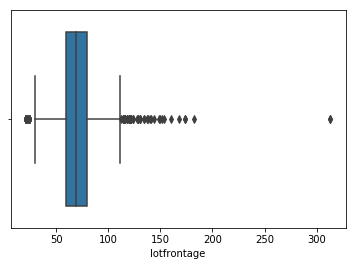

In [87]:
sns.boxplot(df.loc[df.lotfrontage.notnull()].lotfrontage)

In [89]:
Q1 = df.quantile(0.25)
Q3 = df.quantile(0.75)
IQR = Q3 - Q1

In [100]:
outliers_up = Q3 + 1.5 * IQR
outliers_down = Q1 - 1.5 * IQR

In [101]:
# outliers up
df.loc[df.lotfrontage >= outliers_up.lotfrontage, 'lotfrontage'].count()

46

In [102]:
df.loc[df.lotfrontage <= outliers_down.lotfrontage, 'lotfrontage'].count()

42

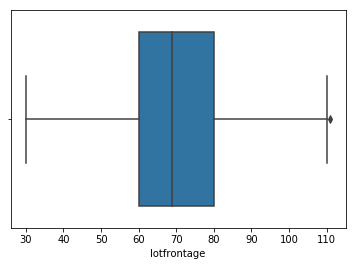

In [103]:
sns.boxplot(df.loc[(df.lotfrontage.notnull()) & (df.loc[df.lotfrontage <= outliers_up.lotfrontage, 'lotfrontage']) 
                   & (df.lotfrontage >= outliers_down.lotfrontage)].lotfrontage)

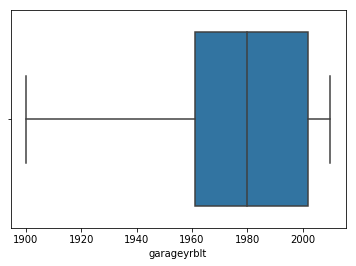

In [88]:
sns.boxplot(df.loc[df.garageyrblt.notnull()].garageyrblt)

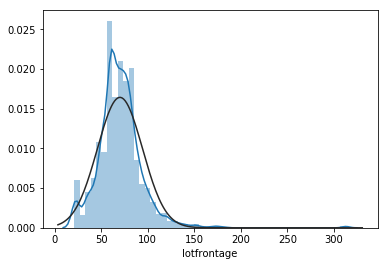

In [105]:
from scipy.stats import norm
sns.distplot(df.loc[df.lotfrontage.notnull()].lotfrontage, fit=norm)

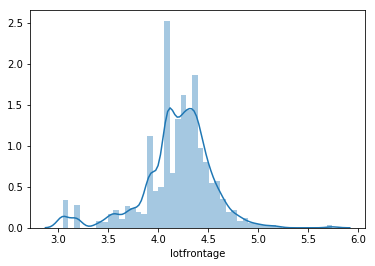

In [106]:
sns.distplot(pd.np.log(df.loc[df.lotfrontage.notnull()].lotfrontage))

In [43]:
columns = ["poolqc", "miscfeature", "fence", "alley", "fireplacequ", "garagetype", "garagequal", "garagefinish", 
           "garagecond", "bsmtfintype2",
           "bsmtexposure", "bsmtqual", "bsmtcond", "bsmtfintype1", "masvnrtype"]

#df.loc[:,columns] = df.loc[:,columns].cat.add_categories("N").fillna("N")
df.loc[:,columns].apply(lambda x: print(x) if x.isna())

SyntaxError: invalid syntax (<ipython-input-43-6790b46796e0>, line 6)

In [17]:
?pd.DataFrame.sort_values

In [5]:
df.describe().T

count           mean           std      min        25%  \
lotfrontage    1201.0      70.049958     24.284752     21.0      59.00   
lotarea        1460.0   10516.828082   9981.264932   1300.0    7553.50   
yearbuilt      1460.0    1971.267808     30.202904   1872.0    1954.00   
yearremodadd   1460.0    1984.865753     20.645407   1950.0    1967.00   
masvnrarea     1452.0     103.685262    181.066207      0.0       0.00   
bsmtfinsf1     1460.0     443.639726    456.098091      0.0       0.00   
bsmtfinsf2     1460.0      46.549315    161.319273      0.0       0.00   
bsmtunfsf      1460.0     567.240411    441.866955      0.0     223.00   
totalbsmtsf    1460.0    1057.429452    438.705324      0.0     795.75   
1stflrsf       1460.0    1162.626712    386.587738    334.0     882.00   
2ndflrsf       1460.0     346.992466    436.528436      0.0       0.00   
lowqualfinsf   1460.0       5.844521     48.623081      0.0       0.00   
grlivarea      1460.0    1515.463699    525.480383    334.0    1129.50   
bsmtfullbath   1460.0       0.425342      0.518911      0.0       0.00   
bsmthalfbath   1460.0       0.057534      0.238753      0.0       0.00   
fullbath       1460.0       1.565068      0.550916      0.0       1.00   
halfbath       1460.0       0.382877      0.502885      0.0       0.00   
bedroomabvgr   1460.0       2.866438      0.815778      0.0       2.00   
kitchenabvgr   1460.0       1.046575      0.220338      0.0       1.00   
totrmsabvgrd   1460.0       6.517808      1.625393      2.0       5.00   
fireplaces     1460.0       0.613014      0.644666      0.0       0.00   
garageyrblt    1379.0    1978.506164     24.689725   1900.0    1961.00   
garagecars     1460.0       1.767123      0.747315      0.0       1.00   
garagearea     1460.0     472.980137    213.804841      0.0     334.50   
wooddecksf     1460.0      94.244521    125.338794      0.0       0.00   
openporchsf    1460.0      46.660274     66.256028      0.0       0.00   
enclosedporch  1460.0      21.954110     61.119149      0.0       0.00   
3ssnporch      1460.0       3.409589     29.317331      0.0       0.00   
screenporch    1460.0      15.060959     55.757415      0.0       0.00   
poolarea       1460.0       2.758904     40.177307      0.0       0.00   
miscval        1460.0      43.489041    496.123024      0.0       0.00   
mosold         1460.0       6.321918      2.703626      1.0       5.00   
yrsold         1460.0    2007.815753      1.328095   2006.0    2007.00   
saleprice      1460.0  180921.195890  79442.502883  34900.0  129975.00   

                    50%        75%       max  
lotfrontage        69.0      80.00     313.0  
lotarea          9478.5   11601.50  215245.0  
yearbuilt        1973.0    2000.00    2010.0  
yearremodadd     1994.0    2004.00    2010.0  
masvnrarea          0.0     166.00    1600.0  
bsmtfinsf1        383.5     712.25    5644.0  
bsmtfinsf2          0.0       0.00    1474.0  
bsmtunfsf         477.5     808.00    2336.0  
totalbsmtsf       991.5    1298.25    6110.0  
1stflrsf         1087.0    1391.25    4692.0  
2ndflrsf            0.0     728.00    2065.0  
lowqualfinsf        0.0       0.00     572.0  
grlivarea        1464.0    1776.75    5642.0  
bsmtfullbath        0.0       1.00       3.0  
bsmthalfbath        0.0       0.00       2.0  
fullbath            2.0       2.00       3.0  
halfbath            0.0       1.00       2.0  
bedroomabvgr        3.0       3.00       8.0  
kitchenabvgr        1.0       1.00       3.0  
totrmsabvgrd        6.0       7.00      14.0  
fireplaces          1.0       1.00       3.0  
garageyrblt      1980.0    2002.00    2010.0  
garagecars          2.0       2.00       4.0  
garagearea        480.0     576.00    1418.0  
wooddecksf          0.0     168.00     857.0  
openporchsf        25.0      68.00     547.0  
enclosedporch       0.0       0.00     552.0  
3ssnporch           0.0       0.00     508.0  
screenporch         0.0       0.00     480.0  
poolarea       

In [6]:
df.describe(include=["category"]).T

count unique      top  freq
mssubclass     1460     15       20   536
mszoning       1460      5       RL  1151
street         1460      2     Pave  1454
alley            91      2     Grvl    50
lotshape       1460      4      Reg   925
landcontour    1460      4      Lvl  1311
utilities      1460      2   AllPub  1459
lotconfig      1460      5   Inside  1052
landslope      1460      3      Gtl  1382
neighborhood   1460     25    NAmes   225
condition1     1460      9     Norm  1260
condition2     1460      8     Norm  1445
bldgtype       1460      5     1Fam  1220
housestyle     1460      8   1Story   726
overallqual    1460     10        5   397
overallcond    1460      9        5   821
roofstyle      1460      6    Gable  1141
roofmatl       1460      8  CompShg  1434
exterior1st    1460     15  VinylSd   515
exterior2nd    1460     16  VinylSd   504
masvnrtype     1452      4     None   864
exterqual      1460      4       TA   906
extercond      1460      5       TA  1282
foundation     1460      6    PConc   647
bsmtqual       1423      4       TA   649
bsmtcond       1423      4       TA  1311
bsmtexposure   1422      4       No   953
bsmtfintype1   1423      6      Unf   430
bsmtfintype2   1422      6      Unf  1256
heating        1460      6     GasA  1428
heatingqc      1460      5       Ex   741
centralair     1460      2        Y  1365
electrical     1459      5    SBrkr  1334
kitchenqual    1460      4       TA   735
functional     1460      7      Typ  1360
fireplacequ     770      5       Gd   380
garagetype     1379      6   Attchd   870
garagefinish   1379      3      Unf   605
garagequal     1379      5       TA  1311
garagecond     1379      5       TA  1326
paveddrive     1460      3        Y  1340
poolqc            7      3       Gd     3
fence           281      4    MnPrv   157
miscfeature      54      4     Shed    49
saletype       1460      9       WD  1267
salecondition  1460      6   Normal  1198

In [7]:
df.saleprice.describe().astype("int64")

count      1460
mean     180921
std       79442
min       34900
25%      129975
50%      163000
75%      214000
max      755000
Name: saleprice, dtype: int64

[None, None]

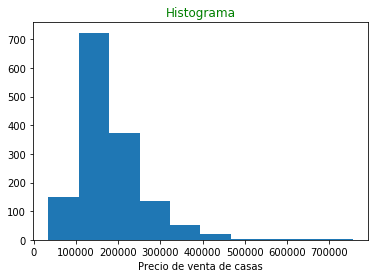

In [10]:
plt.hist(df.saleprice)
plt.xlabel("Precio de venta de casas")
title_obj = plt.title('Histograma')
plt.setp(title_obj, color='g') 

In [11]:
print("Skewness: %f" % df.saleprice.skew())
print("Kurtosis: %f" % df.saleprice.kurt())

Skewness: 1.882876
Kurtosis: 6.536282


Text(0.5, 1.0, 'precio de venta de casas')

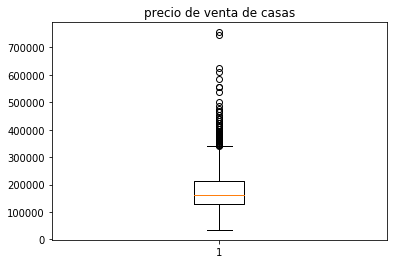

In [115]:
plt.boxplot(df.saleprice)
plt.title("precio de venta de casas")

Obteniendo los outliers

In [12]:
Q1 = df.quantile(0.25)
Q3 = df.quantile(0.75)
IQR = Q3 - Q1
print(IQR)

lotfrontage         21.00
lotarea           4048.00
yearbuilt           46.00
yearremodadd        37.00
masvnrarea         166.00
bsmtfinsf1         712.25
bsmtfinsf2           0.00
bsmtunfsf          585.00
totalbsmtsf        502.50
1stflrsf           509.25
2ndflrsf           728.00
lowqualfinsf         0.00
grlivarea          647.25
bsmtfullbath         1.00
bsmthalfbath         0.00
fullbath             1.00
halfbath             1.00
bedroomabvgr         1.00
kitchenabvgr         0.00
totrmsabvgrd         2.00
fireplaces           1.00
garageyrblt         41.00
garagecars           1.00
garagearea         241.50
wooddecksf         168.00
openporchsf         68.00
enclosedporch        0.00
3ssnporch            0.00
screenporch          0.00
poolarea             0.00
miscval              0.00
mosold               3.00
yrsold               2.00
saleprice        84025.00
dtype: float64


In [13]:
outliers_menores = df.loc[df.saleprice < Q1.saleprice]
outliers_mayores = df.loc[df.saleprice > Q3.saleprice]
print("Cantidad de outliers: %s" % str(len(outliers_menores)  + len(outliers_mayores)))
print("Cantidad de datos: %s" % df.shape[0])
print("Porcentaje:"+ '%.3f' % ((len(outliers_menores)  + len(outliers_mayores)) / df.shape[0]))

Cantidad de outliers: 727
Cantidad de datos: 1460
Porcentaje:0.498


Text(0.5, 1.0, 'precio de venta de casas')

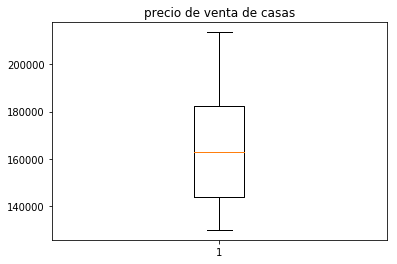

In [14]:
plt.boxplot(df.loc[(df.saleprice > Q1.saleprice)  & (df.saleprice < Q3.saleprice)].saleprice)
plt.title("precio de venta de casas")

### Identificación de variables de interés

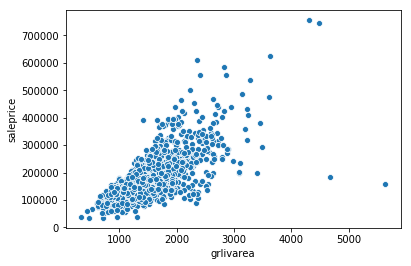

In [15]:
sns.scatterplot(data=df, x="grlivarea", y="saleprice")

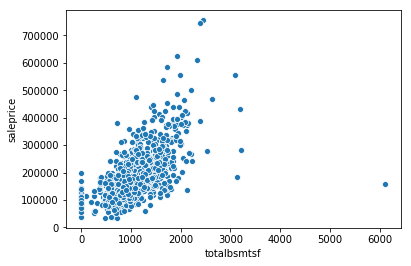

In [16]:
sns.scatterplot(data=df, x="totalbsmtsf", y="saleprice")

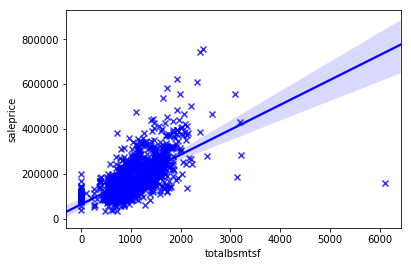

In [17]:
sns.regplot(data=df, x="totalbsmtsf", y="saleprice", color="b", marker="x")

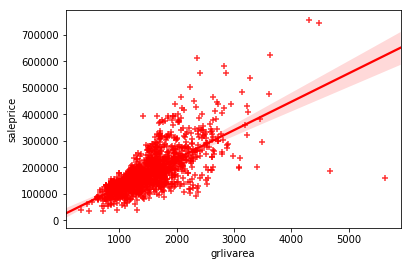

In [18]:
sns.regplot(data=df, x="grlivarea", y="saleprice", color="r", marker="+")

Relación de la variable objetivo frente a dimensiones con valores categóricos.

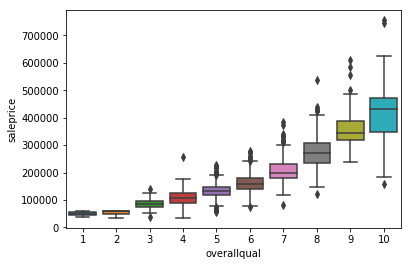

In [19]:
sns.boxplot(data=df, x="overallqual", y="saleprice")

Veamos el precio de venta contra le año de construcción.

In [95]:
df.yearbuilt.max()
df.yearbuilt.min()

1872

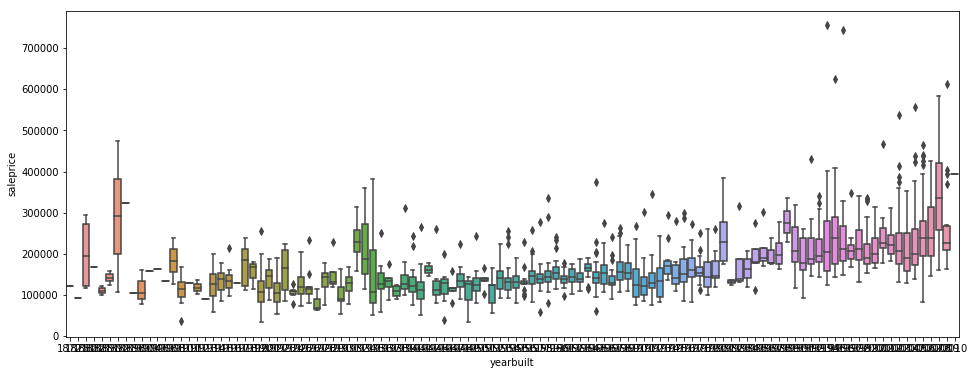

In [20]:
plt.figure(figsize=(16, 6))
g = sns.boxplot(data=df, x="yearbuilt", y="saleprice")

### Análisis bivariado

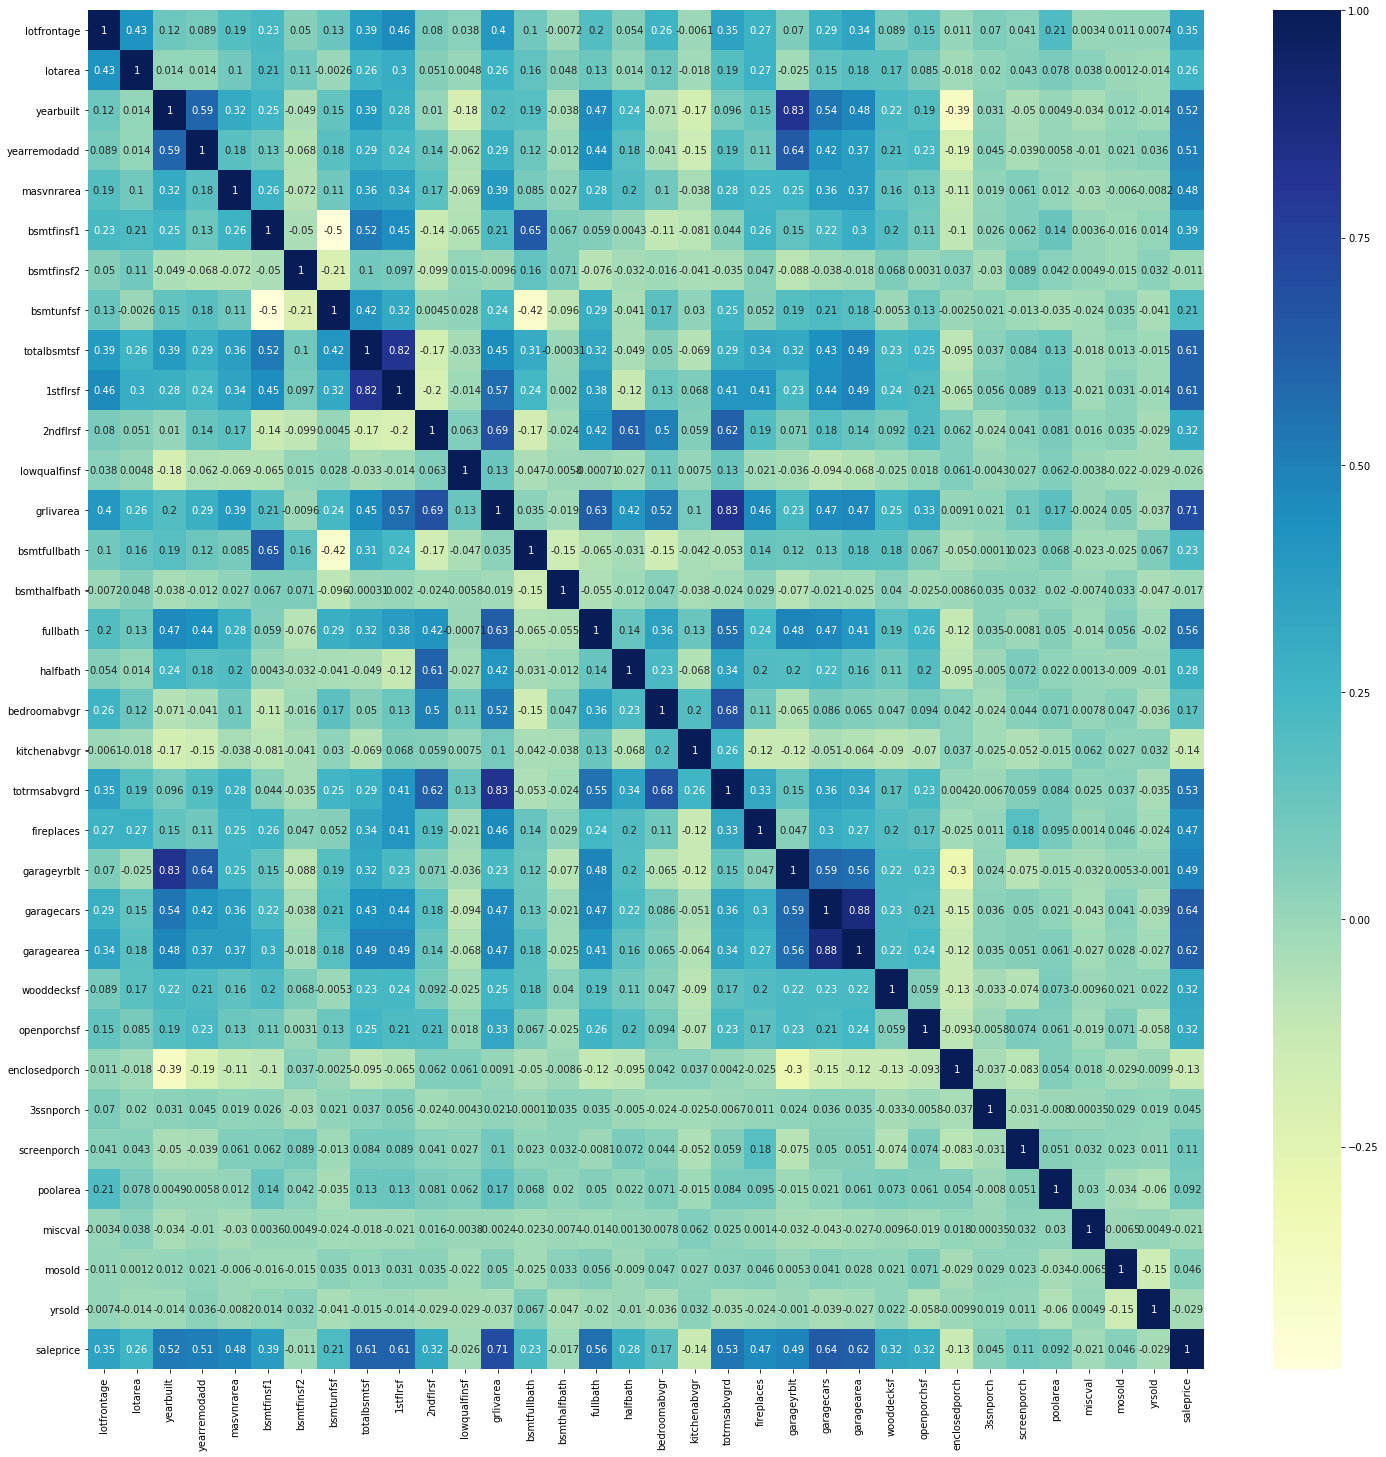

In [21]:
plt.figure(figsize=(25, 25))
sns.heatmap(df.corr(), annot=True, cmap="YlGnBu")

In [22]:
df.corr().loc[df.corr().saleprice > 0.5, 'saleprice'].sort_values()

yearremodadd    0.507101
yearbuilt       0.522897
totrmsabvgrd    0.533723
fullbath        0.560664
1stflrsf        0.605852
totalbsmtsf     0.613581
garagearea      0.623431
garagecars      0.640409
grlivarea       0.708624
saleprice       1.000000
Name: saleprice, dtype: float64

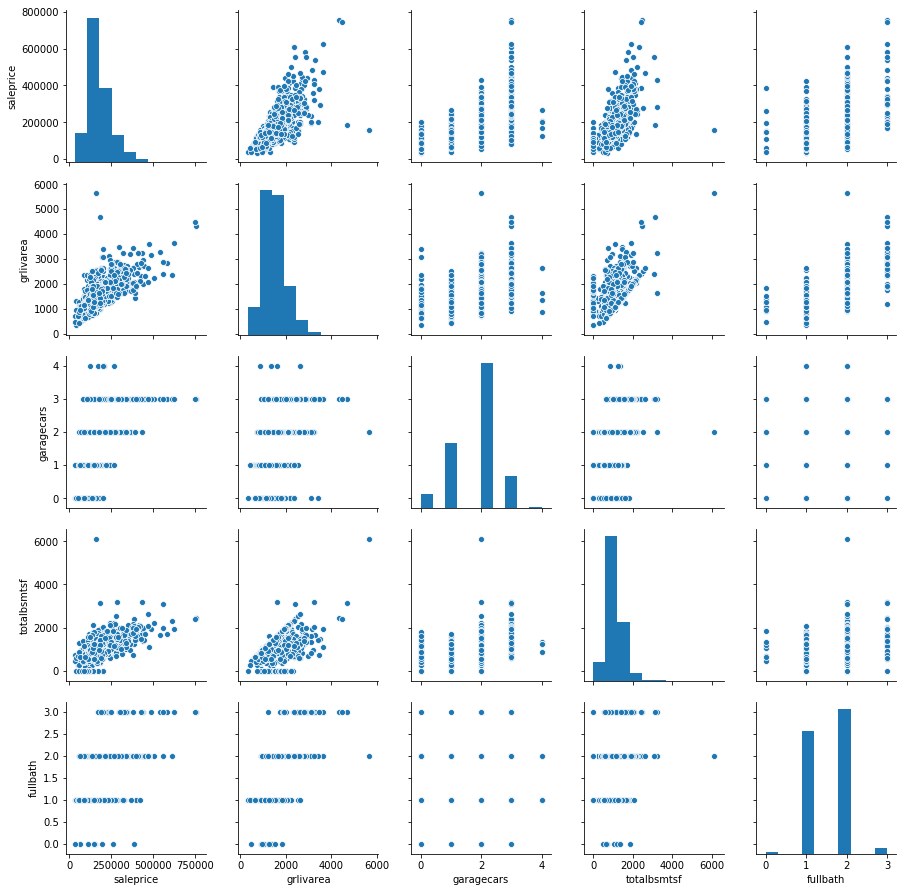

In [25]:
variables = ['saleprice', 'grlivarea', 'garagecars', 'totalbsmtsf', 'fullbath']
sns.pairplot(df.loc[:, variables])

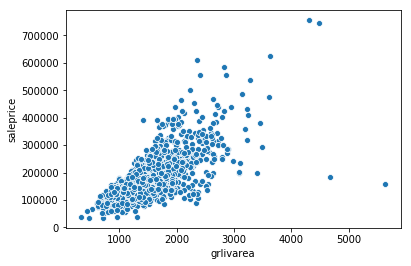

In [26]:
sns.scatterplot(data=df, x="grlivarea", y="saleprice")

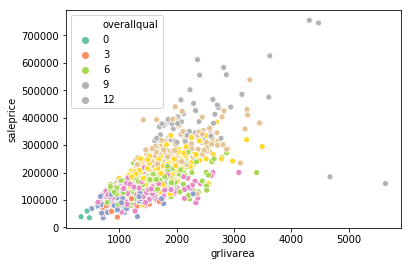

In [40]:
sns.scatterplot(data=df, x="grlivarea", y="saleprice", hue=df.overallqual.astype("int64"), palette="Set2")

In [43]:
#df.loc[df.grlivarea > 4500,].T
df.loc[df.grlivarea > 4500,].head()

mssubclass mszoning  lotfrontage  lotarea street alley lotshape  \
Id                                                                     
524          60       RL        130.0    40094   Pave   NaN      IR1   
1299         60       RL        313.0    63887   Pave   NaN      IR3   

     landcontour utilities lotconfig  ... poolarea poolqc fence miscfeature  \
Id                                    ...                                     
524          Bnk    AllPub    Inside  ...        0    NaN   NaN         NaN   
1299         Bnk    AllPub    Corner  ...      480     Gd   NaN         NaN   

     miscval mosold yrsold saletype  salecondition  saleprice  
Id                                                             
524        0     10   2007      New        Partial     184750  
1299       0      1   2008      New        Partial     160000  

[2 rows x 80 columns]

Agreguemos una dimensión y respondamos ¿influye la planitud, es decir, la calidad de plano?

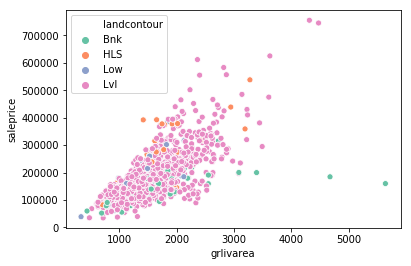

In [49]:
sns.scatterplot(data=df, x="grlivarea", y="saleprice", hue=df.landcontour, palette="Set2")

Vamos a separar el anterior plot a través de la variable de planitud.

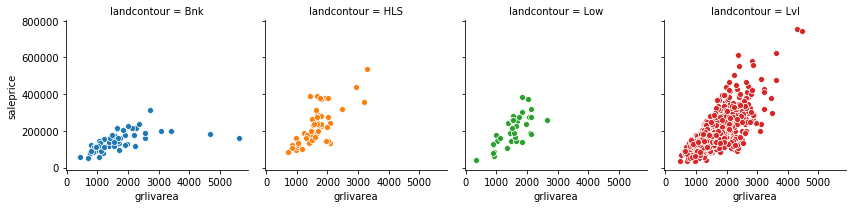

In [63]:
#plt.figure(figsize=(20, 20))
g = sns.FacetGrid(df, col="landcontour", hue="landcontour")
g.map(sns.scatterplot,"grlivarea", "saleprice")

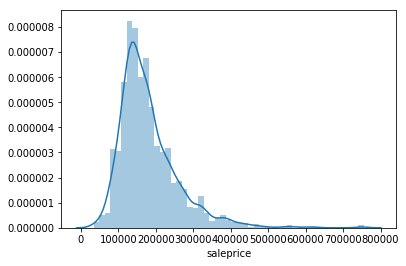

In [71]:
sns.distplot(df.saleprice)

_En búsqueda de la normalidad_

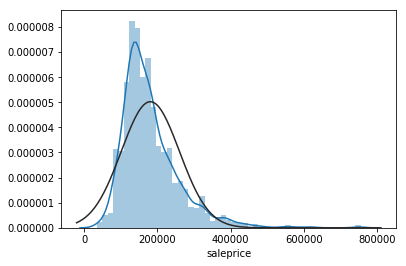

In [72]:
from scipy.stats import norm
sns.distplot(df.saleprice, fit=norm)

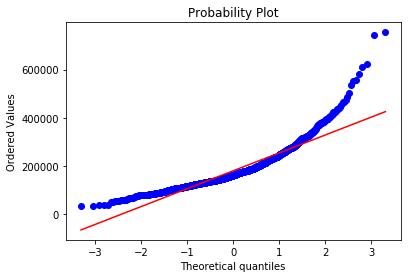

In [81]:
from scipy import stats

res = stats.probplot(df.saleprice, plot=plt)

In [76]:
res

((array([-3.30513952, -3.04793228, -2.90489705, ...,  2.90489705,
          3.04793228,  3.30513952]),
  array([ 34900,  35311,  37900, ..., 625000, 745000, 755000], dtype=int64)),
 (74160.16474519415, 180921.19589041095, 0.9319665641512986))

Vamos a aplicar una transformación en los datos para resolver el problema en saleprice. Para este caso (un sesgo positivo) podemos aplicar una transformación logarítmica que usualmente funciona bastante bien. 

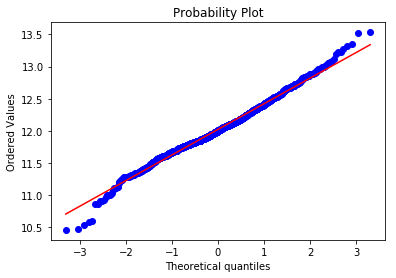

In [83]:
res = stats.probplot(pd.np.log(df.saleprice), plot=plt)

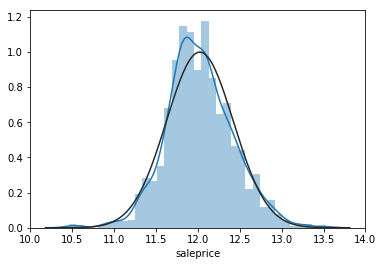

In [84]:
sns.distplot(pd.np.log(df.saleprice), fit=norm)

**Este mismo proceso lo podemos realizar con las variables grlivarea y totalbsmtsf, pero ¡ojo!.**

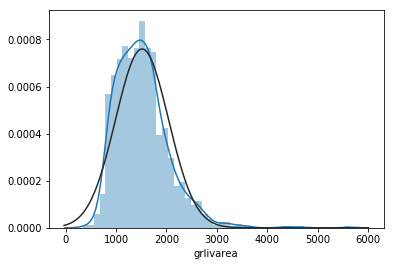

In [89]:
sns.distplot(df.grlivarea, fit=norm)

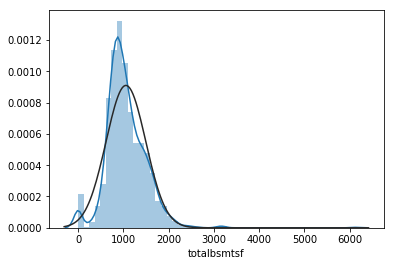

In [88]:
sns.distplot(df.totalbsmtsf, fit=norm)

In [92]:
df.grlivarea.describe()

count    1460.000000
mean     1515.463699
std       525.480383
min       334.000000
25%      1129.500000
50%      1464.000000
75%      1776.750000
max      5642.000000
Name: grlivarea, dtype: float64

In [90]:
df.totalbsmtsf.describe()

count    1460.000000
mean     1057.429452
std       438.705324
min         0.000000
25%       795.750000
50%       991.500000
75%      1298.250000
max      6110.000000
Name: totalbsmtsf, dtype: float64

Tenemos un problema y es por la cantidad de sitios que no tienen sótano , ¿Qué podríamos hacer con estos datos? 
+ ¿Decisiones?
+ ¿Borrarlos?
+ ¿Separarlos?
+ ¿Una nueva variable?
+ ¿Asignarles un valor? ¿Cuál?

Nuestra decisión será separar la información y realizar los análisis sobre los datos que no tienen 0, específicamente, el 0,02%. 

In [99]:
df.loc[df.totalbsmtsf == 0].shape[0] / df.shape[0]

0.025342465753424658

In [100]:
df_separados = df.loc[df.totalbsmtsf == 0].copy()

((array([-3.29794035, -3.04021209, -2.89685519, ...,  2.89685519,
          3.04021209,  3.29794035]),
  array([4.65396035, 5.24702407, 5.5759491 , ..., 8.07090609, 8.07277933,
         8.71768205])),
 (0.35851584053637514, 6.925031281845184, 0.9905075670866059))

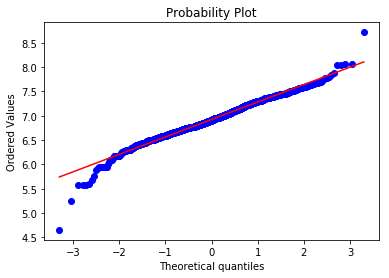

In [101]:
stats.probplot(pd.np.log(df.loc[df.totalbsmtsf > 0].totalbsmtsf), plot=plt)

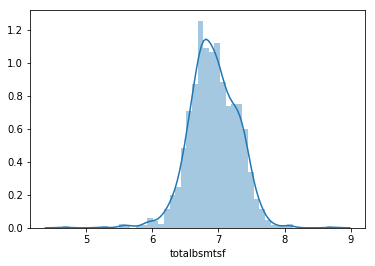

In [103]:
sns.distplot(pd.np.log(df.loc[df.totalbsmtsf > 0].totalbsmtsf))

_En búsqueda de la Homocedasticidad_

_grlivarea_

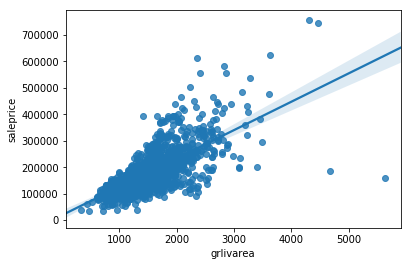

In [107]:
# antes
sns.regplot(df.grlivarea, df.saleprice)

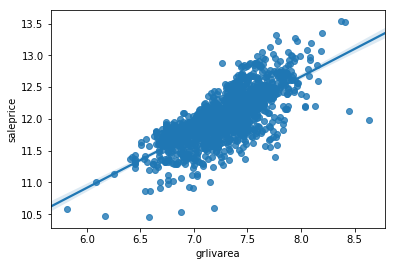

In [106]:
# despues
sns.regplot(pd.np.log(df.grlivarea), pd.np.log(df.saleprice))

_totalbsmtsf_

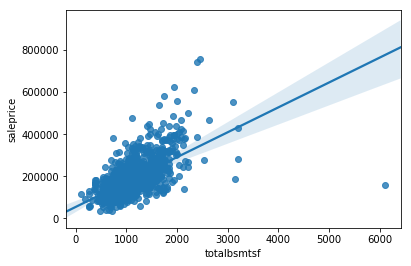

In [109]:
# antes
sns.regplot(df.loc[df.totalbsmtsf > 0].totalbsmtsf, df.loc[df.totalbsmtsf > 0].saleprice)

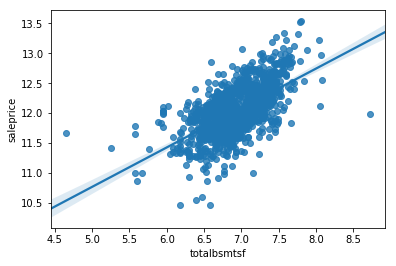

In [110]:
# despues
sns.regplot(pd.np.log(df.loc[df.totalbsmtsf > 0].totalbsmtsf), pd.np.log(df.loc[df.totalbsmtsf > 0].saleprice))

### variables dummy

In [111]:
df_dummy = pd.get_dummies(df)
df_dummy.columns

Index(['lotfrontage', 'lotarea', 'yearbuilt', 'yearremodadd', 'masvnrarea',
       'bsmtfinsf1', 'bsmtfinsf2', 'bsmtunfsf', 'totalbsmtsf', '1stflrsf',
       ...
       'saletype_ConLw', 'saletype_New', 'saletype_Oth', 'saletype_WD',
       'salecondition_Abnorml', 'salecondition_AdjLand',
       'salecondition_Alloca', 'salecondition_Family', 'salecondition_Normal',
       'salecondition_Partial'],
      dtype='object', length=320)